## Objective

#### NLP sentiment classification on news headlines
Using APIs or a little webscraping to harvest some new test data that you will manually label the new headlines as negative/positive and then see how your model does on those headlines.

#### Dataset:
[Sentiment Analysis for Financial News](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models.doc2vec import TaggedDocument
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#to see the entire column width:
pd.set_option('display.max_colwidth', -1)

In [2]:
import tensorflow as tf
tf.__version__

'2.3.1'

### Imoport Data

In [3]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

Sentiment  \
0  positive   
1  neutral    
2  positive   
3  positive   
4  positive   

                                                                                                                                                                                                                                            Headline  
0  Salo , Finland , 29 August 2006 - Benefon has today announced its plans to further strengthen its in-house technology platform , by licensing the complete mobile software platform , Opna , from its long-standing technology partner , Pollex .  
1  The company offers payroll services , including payroll processing , payroll tax administration , and employee pay services , including direct deposit , check signing , and Readychex .                                                           
2  Thereby , the company will expand its offering to North , Central and South America .                                                                                                                                                              
3  Cash flow from operations totalled EUR 7.4 mn , compared to a negative EUR 68.6 mn in the second quarter of 2008 .                                                                                                                                 
4  EBIT excluding non-recurring items was estimated to increase from 2009 .

Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [4]:
# Look at the instances of each sentiment
df.Sentiment.value_counts()

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

#### Visualize the data

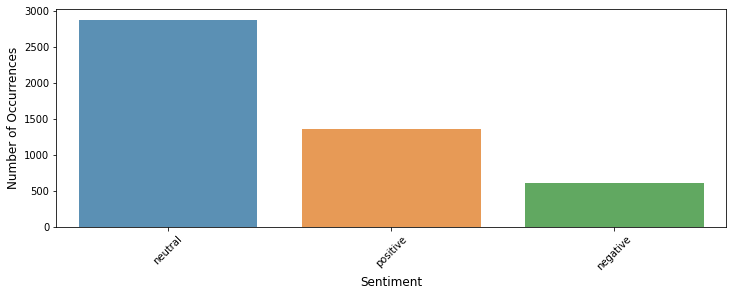

In [5]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show();

### Clean the Data

In [6]:
# Convert the string in the 'Sentiment' column to numeric form
Sentiment = {'positive': 0, 'neutral': 1, 'negative': 2} 

#df[Sentiment]=df[Sentiment].map(Sentiment)

In [7]:
# traversing through Sentiment column and writing values where key matches
df.Sentiment = [Sentiment[item] for item in df.Sentiment] 
df.head(10)

Sentiment  \
0  0           
1  1           
2  0           
3  0           
4  0           
5  1           
6  1           
7  1           
8  1           
9  1           

                                                                                                                                                                                                                                            Headline  
0  Salo , Finland , 29 August 2006 - Benefon has today announced its plans to further strengthen its in-house technology platform , by licensing the complete mobile software platform , Opna , from its long-standing technology partner , Pollex .  
1  The company offers payroll services , including payroll processing , payroll tax administration , and employee pay services , including direct deposit , check signing , and Readychex .                                                           
2  Thereby , the company will expand its offering to North , Central and South America .                                                                                                                                                              
3  Cash flow from operations totalled EUR 7.4 mn , compared to a negative EUR 68.6 mn in the second quarter of 2008 .                                                                                                                                 
4  EBIT excluding non-recurring items was estimated to increase from 2009 .                                                                                                                                                                           
5  With this acquisition the wireless modem unit and its approximately 1,100 employees were transferred to Renesas Electronics Corporation .                                                                                                          
6  The right margin will be viewed separately in detail with every customer .                                                                                                                                                                         
7  The expanded agreement covers the sale , marketing and distribution of Benefon 's navigation and locator devices in China .                                                                                                                        
8  The record date for dividend distribution is March 14 , 2008 .                                                                                                                                                                                     
9  The European Central Bank ECB is anticipated to raise its benchmark interest rate in the second half of 2011 at the earliest .

#### Stopwords:
Remove words from strings that have no unique information ('is','an','the).

In [8]:
#nltk.download('stopwords')

stop = set(stopwords.words('english'))
stop.add("'s")
for item in string.punctuation:
    stop.add (item)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [9]:
#make a new column for clean headlines and then other columns for different version of data

In [10]:
#check
df.head()

Sentiment  \
0  0           
1  1           
2  0           
3  0           
4  0           

                                                                                                                                                                                     Headline  
0  salo finland 29 august 2006 benefon today announced plans strengthen in-house technology platform licensing complete mobile software platform opna long-standing technology partner pollex  
1  company offers payroll services including payroll processing payroll tax administration employee pay services including direct deposit check signing readychex                              
2  thereby company expand offering north central south america                                                                                                                                 
3  cash flow operations totalled eur 7.4 mn compared negative eur 68.6 mn second quarter 2008                                                                                                  
4  ebit excluding non-recurring items estimated increase 2009

#### Lemmatization:
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)

In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline_Lemma'] = df['Headline'].map(lemmatize)

In [13]:
#check
df.head()

Sentiment  \
0  0           
1  1           
2  0           
3  0           
4  0           

                                                                                                                                                                                     Headline  \
0  salo finland 29 august 2006 benefon today announced plans strengthen in-house technology platform licensing complete mobile software platform opna long-standing technology partner pollex   
1  company offers payroll services including payroll processing payroll tax administration employee pay services including direct deposit check signing readychex                               
2  thereby company expand offering north central south america                                                                                                                                  
3  cash flow operations totalled eur 7.4 mn compared negative eur 68.6 mn second quarter 2008                                                                                                   
4  ebit excluding non-recurring items estimated increase 2009                                                                                                                                   

                                                                                                                                                                             Headline_Lemma  
0  salo finland 29 august 2006 benefon today announce plan strengthen in-house technology platform licensing complete mobile software platform opna long-standing technology partner pollex  
1  company offer payroll service include payroll processing payroll tax administration employee pay service include direct deposit check signing readychex                                   
2  thereby company expand offering north central south america                                                                                                                               
3  cash flow operation total eur 7.4 mn compare negative eur 68.6 mn second quarter 2008                                                                                                     
4  ebit exclude non-recurring item estimate increase 2009

WordCloud to see the commonly used words

In [14]:
#!pip install wordcloud

In [15]:
# Separating out the categories
# pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
# neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [16]:
def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1000, 
                          height = 600,
                          collocations=False).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds(column='Headline'):
    # Separating out the categories
    pos = df[column][df.Sentiment[df.Sentiment== 1].index]
    neg = df[column][df.Sentiment[df.Sentiment== 0].index]
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    

Positive Sentiment Wordcloud:


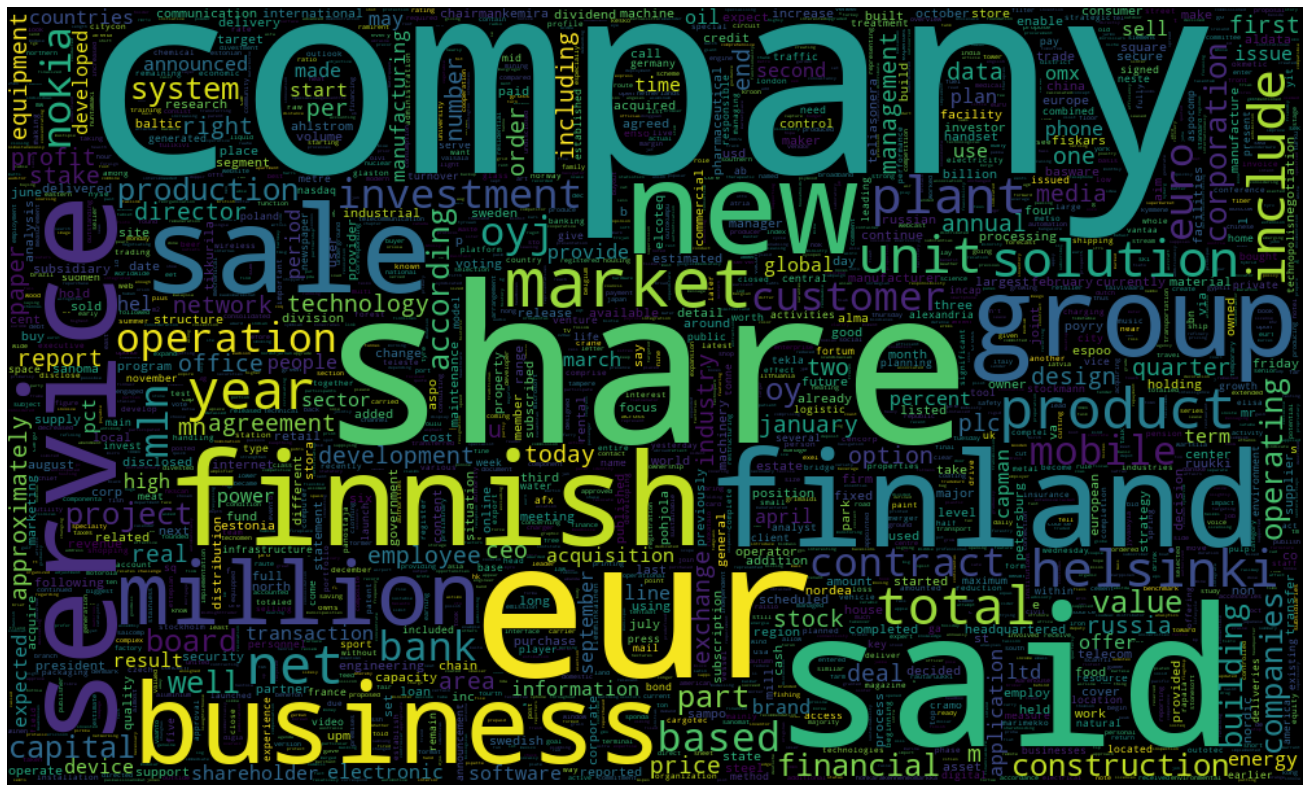

Negative Sentiment Wordcloud:


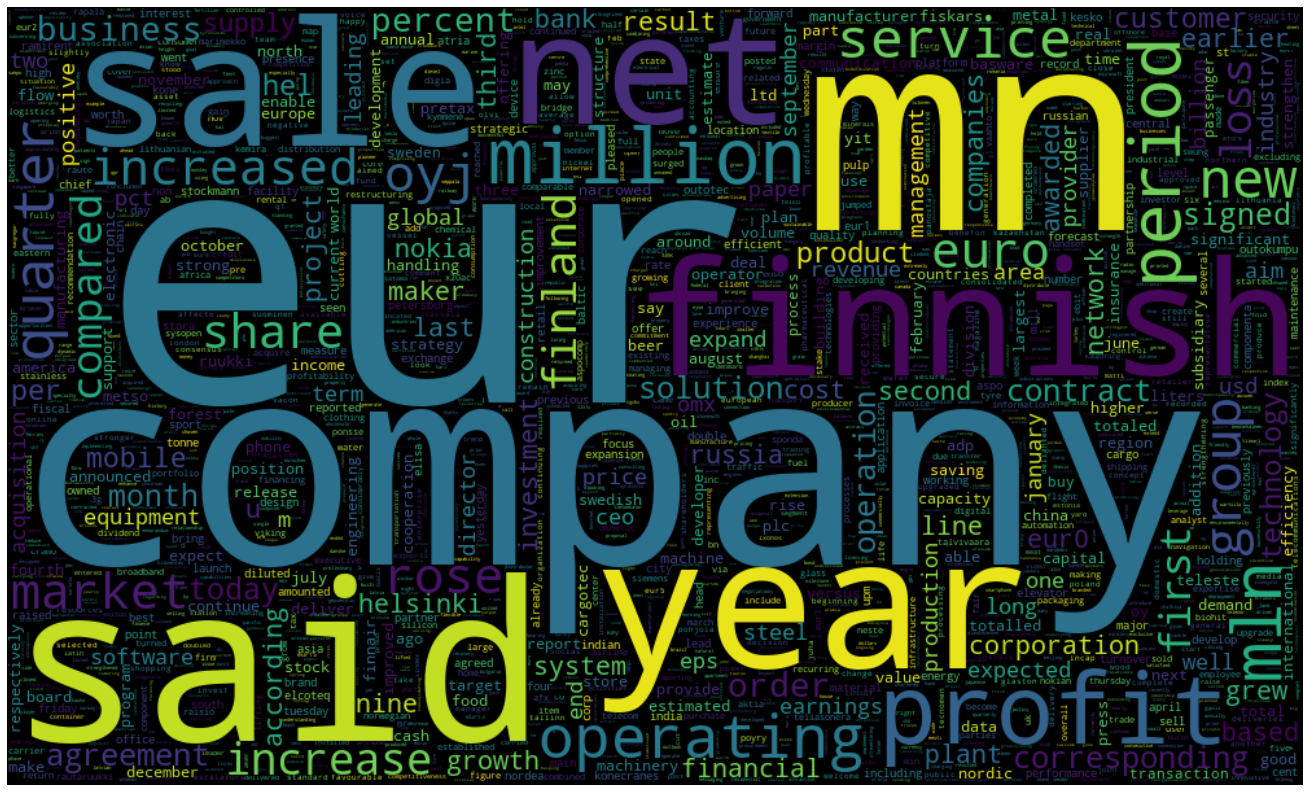

In [17]:
show_wordclouds()

Positive Sentiment Wordcloud:


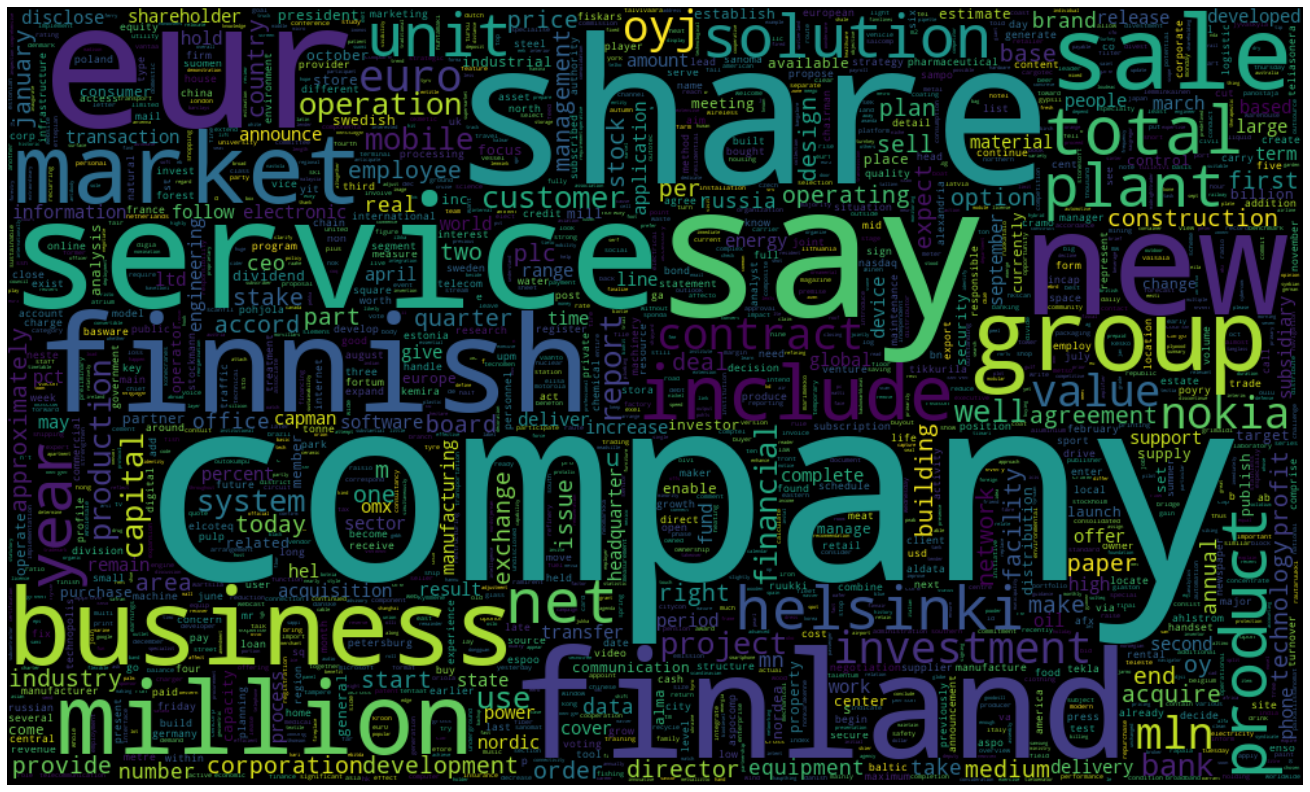

Negative Sentiment Wordcloud:


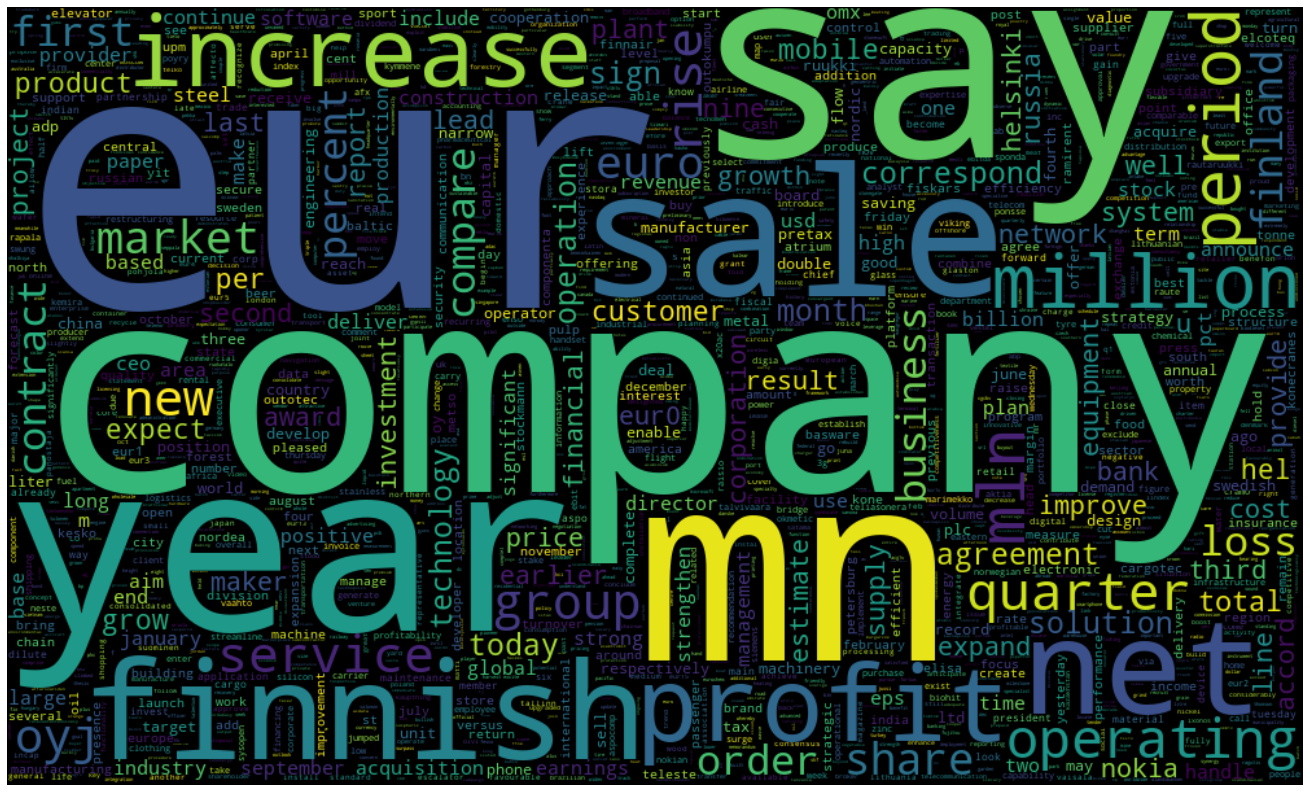

In [18]:
show_wordclouds('Headline_Lemma')

Process the text to convert text to lower-case strip punctuations and symbols etc.

In [19]:
from bs4 import BeautifulSoup
import re

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text


df['Headline_soup'] = df['Headline_Lemma'].apply(cleanText)


In [20]:
df.head()

Sentiment  \
0  0           
1  1           
2  0           
3  0           
4  0           

                                                                                                                                                                                     Headline  \
0  salo finland 29 august 2006 benefon today announced plans strengthen in-house technology platform licensing complete mobile software platform opna long-standing technology partner pollex   
1  company offers payroll services including payroll processing payroll tax administration employee pay services including direct deposit check signing readychex                               
2  thereby company expand offering north central south america                                                                                                                                  
3  cash flow operations totalled eur 7.4 mn compared negative eur 68.6 mn second quarter 2008                                                                                                   
4  ebit excluding non-recurring items estimated increase 2009                                                                                                                                   

                                                                                                                                                                             Headline_Lemma  \
0  salo finland 29 august 2006 benefon today announce plan strengthen in-house technology platform licensing complete mobile software platform opna long-standing technology partner pollex   
1  company offer payroll service include payroll processing payroll tax administration employee pay service include direct deposit check signing readychex                                    
2  thereby company expand offering north central south america                                                                                                                                
3  cash flow operation total eur 7.4 mn compare negative eur 68.6 mn second quarter 2008                                                                                                      
4  ebit exclude non-recurring item estimate increase 2009                                                                                                                                     

                                                                                                                                                                             Headline_soup  
0  salo finland 29 august 2006 benefon today announce plan strengthen in-house technology platform licensing complete mobile software platform opna long-standing technology partner polle  
1  company offer payroll service include payroll processing payroll ta administration employee pay service include direct deposit check signing readyche                                    
2  thereby company epand offering north central south america                                                                                                                               
3  cash flow operation total eur 7.4 mn compare negative eur 68.6 mn second quarter 2008                                                                                                    
4  ebit eclude non-recurring item estimate increase 2009

#### Counter

In [21]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [22]:
text = df.Headline_Lemma
counter = counter_word(text)

In [23]:
len(counter)

10088

In [24]:
num_words = len(counter)

### Train/Test Split

In [25]:
# headlines = []
# labels = []

# for row in range(len(df)):
#     headlines.append(df['Headline_soup'][row])
#     labels.append(df['Sentiment'][row])

In [26]:
training_headlines, testing_headlines, training_labels, testing_labels = train_test_split(
    df['Headline_soup'], df['Sentiment'], test_size=0.2 , random_state=42)

In [27]:
# # Setting the training ratio
# training_size = int(df.shape[0] * .8) 

# # Train Test Split:
# # Already shuffled, so we're good to go
# training_headlines = headlines[0:training_size]
# testing_headlines = headlines[training_size:]
# training_labels = labels[0:training_size]
# testing_labels = labels[training_size:]

In [28]:
# Checking on a few of the headlines:
display(training_headlines[:3])
display(training_labels[:3])

432     also seven-year historic analysis provide market                                  
3071    financial statement interim report release around 9.00 a.m. finnish time give date
289     result enable preparation conceptual plant design capital estimate                
Name: Headline_soup, dtype: object

432     1
3071    1
289     1
Name: Sentiment, dtype: int64

In [29]:
training_labels

432     1
3071    1
289     1
2588    1
4121    1
       ..
4426    1
466     1
3092    0
3772    0
860     1
Name: Sentiment, Length: 3876, dtype: int64

In [30]:
testing_labels

3207    1
1684    1
1044    1
4145    1
1538    2
       ..
3691    1
1507    0
1126    1
180     1
1215    0
Name: Sentiment, Length: 970, dtype: int64

### Tokenizer 
Tokenizing involoves splitting sentances and words from the body of the text
The use of a tokenizer creates a number coded to each word thereby allowing 
the neural network to build patterns and learn meaning.

In [31]:
# function to tokenize text

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [32]:
# apply the splits to the tokenizer

# Gensim is a Python library for topic modeling, document indexing and Similarity retrieval with large corpora.
#[Gensim](https://pypi.org/project/gensim/)
# train_tagged = train.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)
# test_tagged = test.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)

In [33]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(training_headlines)
X_train = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(X_train)
print('Found %s unique tokens.' % len(training_padded))


Found 3876 unique tokens.


In [34]:
# check the shape of data tensor:
X_test = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(X_test, maxlen=max_sequence_length)
print('Shape of data tensor:', testing_padded.shape)

Shape of data tensor: (970, 50)


In [35]:
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [36]:
# # Initializing the fitting the tokenizer:
# tokenizer = Tokenizer(num_words = num_words, oov_token = oov_tok)
# tokenizer.fit_on_texts(training_headlines)
# # Initializing the Word Index:
# word_index = tokenizer.word_index
# # Padding and Sequencing the Training Set:
# training_sequences = tokenizer.texts_to_sequences(training_headlines)
# training_padded = pad_sequences(training_sequences, maxlen = max_length,
#                                padding = padding_type, 
#                                truncating = trunc_type)
# # Padding and Sequencing the Testing Set:
# testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
# testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
#                                padding = padding_type, 
#                                truncating = trunc_type)


In [37]:
# # Switch to Numpy Array
# # Necessary for the ANN to read the data
# training_padded = np.array(training_padded)
# training_labels = np.array(training_labels)
# testing_padded = np.array(testing_padded)
# testing_labels = np.array(testing_labels)

In [106]:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', training_headlines[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 1019   67  232   67 3719  103   15  112   63]

The actual headline:
 cash flow operation total eur 7.4 mn compare negative eur 68.6 mn second quarter 2008

Label:
 0


In [39]:
# train
#train_tagged.values

In [40]:
from tensorflow.keras.utils import to_categorical
training_labels_ohe = to_categorical(training_labels)
testing_labels_ohe = to_categorical(testing_labels)

testing_labels_ohe[0]

array([0., 1., 0.], dtype=float32)

### Model 1 (Hidden Layer)

In [41]:
# embedding_dim = 100

# model = Sequential()
# model.add(Embedding(num_words, embedding_dim, input_length=64))
# model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.2)) # Optional Regularization
# model.add(Dense(3, activation='sigmoid'))

# # Slower learning rate worked better as it kept the learning more stable
# #opt = keras.optimizers.Adam(lr=0.0001)
# model.compile(loss='categorical_crossentropy',optimizer='adam', 
#               metrics=['accuracy']) # Orig code

In [42]:
# num_epochs = 50
# # After 5 epochs of validation loss not improving, the model will stop.
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# history = model.fit(training_padded, training_labels, 
#                     epochs=num_epochs,
#                     batch_size = 10,
#                     validation_data=(testing_padded, testing_labels), 
#                     verbose= 1, callbacks=[es])

### Functions for Model Evaluation:

In [43]:
#results.history.keys()

In [44]:



def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
    
#     history = results.history
#     plt.figure()
#     plt.plot(history['val_loss'])
#     plt.plot(history['loss'])
#     plt.legend(['val_loss', 'loss'])
#     plt.title('Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.show()
    
#     plt.figure()
#     plt.plot(history['val_accuracy'])
#     plt.plot(history['accuracy'])
#     plt.legend(['val_acc', 'acc'])
#     plt.title('Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.show()
    
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
# Made up some easy headlines to see if the ANN works
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
# Random headlines from NYT Business  (post stopword removal and lemmatization) 
# This may be a bit trickier for the network
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

In [45]:
#model_metrics(model)

In [46]:
#test_headlines()

### Model 2 (LSTM):

In [47]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1008800   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,053,219
Trainable params: 1,053,219
Non-trainable params: 0
_________________________________________________________________


In [49]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 24,
                    #validation_data=(testing_padded, testing_labels_ohe), 
                    validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
146/146 [==============================] - 7s 50ms/step - loss: 0.8417 - accuracy: 0.6365 - val_loss: 0.8369 - val_accuracy: 0.6366
Epoch 2/50
146/146 [==============================] - 6s 43ms/step - loss: 0.5802 - accuracy: 0.7483 - val_loss: 0.8500 - val_accuracy: 0.6186
Epoch 3/50
146/146 [==============================] - 7s 46ms/step - loss: 0.2942 - accuracy: 0.8916 - val_loss: 0.9352 - val_accuracy: 0.6933
Epoch 4/50
146/146 [==============================] - 6s 43ms/step - loss: 0.1434 - accuracy: 0.9536 - val_loss: 1.1705 - val_accuracy: 0.6263
Epoch 5/50
146/146 [==============================] - 7s 45ms/step - loss: 0.0870 - accuracy: 0.9745 - val_loss: 1.2691 - val_accuracy: 0.6727
Epoch 6/50
146/146 [==============================] - 6s 43ms/step - loss: 0.0563 - accuracy: 0.9822 - val_loss: 1.4871 - val_accuracy: 0.6598
Epoch 00006: early stopping


In [50]:
y_hat = model.predict(testing_padded)
predicted = y_hat.argmax(axis=1)
true = testing_labels_ohe.argmax(axis=1)

In [51]:
import sklearn.metrics as metrics


print(metrics.classification_report(true,predicted))

              precision    recall  f1-score   support

           0       0.57      0.65      0.61       285
           1       0.79      0.80      0.79       570
           2       0.60      0.38      0.47       115

    accuracy                           0.70       970
   macro avg       0.65      0.61      0.62       970
weighted avg       0.70      0.70      0.70       970



In [52]:
#model_metrics(model)

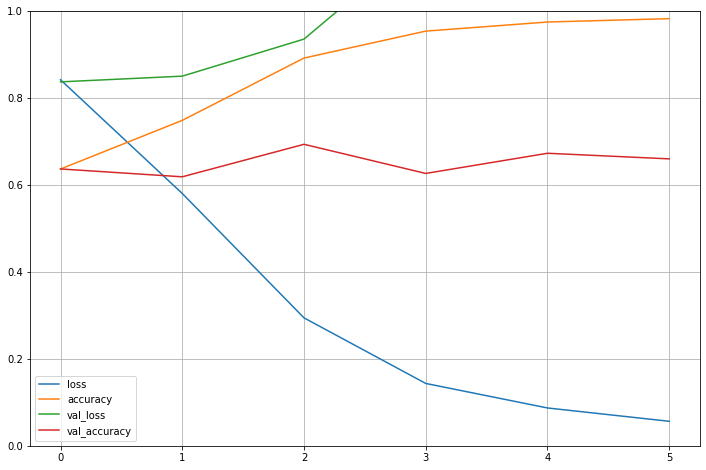

In [53]:
model_eval(history)

In [54]:
embedding_dim = 32

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [55]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 32,
                    validation_data=(testing_padded, testing_labels_ohe), 
                    #validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
122/122 [==============================] - 5s 44ms/step - loss: 0.8926 - accuracy: 0.6076 - val_loss: 0.8000 - val_accuracy: 0.6485
Epoch 2/50
122/122 [==============================] - 5s 39ms/step - loss: 0.6598 - accuracy: 0.6956 - val_loss: 0.7510 - val_accuracy: 0.6691
Epoch 3/50
122/122 [==============================] - 5s 41ms/step - loss: 0.4754 - accuracy: 0.7856 - val_loss: 0.8328 - val_accuracy: 0.6897
Epoch 4/50
122/122 [==============================] - 4s 36ms/step - loss: 0.3498 - accuracy: 0.8318 - val_loss: 0.9363 - val_accuracy: 0.6866
Epoch 5/50
122/122 [==============================] - 5s 37ms/step - loss: 0.2143 - accuracy: 0.9229 - val_loss: 1.0413 - val_accuracy: 0.6907
Epoch 6/50
122/122 [==============================] - 4s 36ms/step - loss: 0.1224 - accuracy: 0.9613 - val_loss: 1.2553 - val_accuracy: 0.6691
Epoch 7/50
122/122 [==============================] - 5s 39ms/step - loss: 0.1045 - accuracy: 0.9659 - val_loss: 1.2638 - val_accuracy: 0.7093

In [56]:
#model_metrics(model)

In [57]:
#model_eval(history) #seperate val and loss

### Import Headlines To Test Model

In [58]:
import requests

url = "https://bloomberg-market-and-financial-news.p.rapidapi.com/news/list-by-region"

querystring = {"id":"home-v3"}

headers = {
    'x-rapidapi-key': "e42e1d27damsh0c4821dfe25b64ap17fdd0jsn1cf1f347448c",
    'x-rapidapi-host': "bloomberg-market-and-financial-news.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"title":null,"id":"home-v3","indexBar":{"enabled":true,"quotes":[{"INDU:IND":{"securityType":"Equity Index","symbol":"INDU","country":"United States","currency":"USD","resourceType":"Index","fundamentalDataCurrency":"USD","resourceSubtype":"Equity","region":"AMERICAS","ticker":"indu:ind","tickerName":"INDU:IND","template":"Index","tinyName":"DOW JONES","name":"DOW JONES","watchlist":true,"resourceId":"INDU:IND","eqtIndex":true,"last":"31539.88","netChange":"17.13","lastPriceTime":1613577361,"pctChange1M":"2.35","yearHigh":"31608.63","dayHigh":"31559.17","volume":125745165,"yearLow":"18213.65","dayLow":"31338.76","pctChangeYTD":"3.05","pctChange":"0.05","isOpen":true,"sparkline":{"href":"https://www.bloomberg.com/markets/api/charts/sparkline/INDU:IND.svg?stroke=2"}}},{"SPX:IND":{"securityType":"Equity Index","symbol":"SPX","country":"United States","currency":"USD","resourceType":"Index","fundamentalDataCurrency":"USD","resourceSubtype":"Equity","region":"AMERICAS","ticker":"spx:ind","

In [59]:
response.json()

{'title': None,
 'id': 'home-v3',
 'indexBar': {'enabled': True,
  'quotes': [{'INDU:IND': {'securityType': 'Equity Index',
     'symbol': 'INDU',
     'country': 'United States',
     'currency': 'USD',
     'resourceType': 'Index',
     'fundamentalDataCurrency': 'USD',
     'resourceSubtype': 'Equity',
     'region': 'AMERICAS',
     'ticker': 'indu:ind',
     'tickerName': 'INDU:IND',
     'template': 'Index',
     'tinyName': 'DOW JONES',
     'name': 'DOW JONES',
     'watchlist': True,
     'resourceId': 'INDU:IND',
     'eqtIndex': True,
     'last': '31539.88',
     'netChange': '17.13',
     'lastPriceTime': 1613577361,
     'pctChange1M': '2.35',
     'yearHigh': '31608.63',
     'dayHigh': '31559.17',
     'volume': 125745165,
     'yearLow': '18213.65',
     'dayLow': '31338.76',
     'pctChangeYTD': '3.05',
     'pctChange': '0.05',
     'isOpen': True,
     'sparkline': {'href': 'https://www.bloomberg.com/markets/api/charts/sparkline/INDU:IND.svg?stroke=2'}}},
   {'SPX:I

In [60]:
results = response.json()
results.keys()

dict_keys(['title', 'id', 'indexBar', 'modules'])

In [61]:

modules = results['modules']
len(modules)

21

Loops to get more stories

In [62]:
titles = []
dates = []
for module in modules:
    for story in module['stories']:
        titles.append(story['title'])
        dates.append(story['id'])

In [63]:
results_df = pd.DataFrame({'id': dates, 'titles': titles})
results_df

id  \
0   2021-02-17/texas-crisis-deepens-economic-fallout-spreads-energy-update                
1   2021-02-17/revlon-debacle-could-turn-citi-into-big-distressed-debt-investor           
2   2021-02-17/at-93-she-waged-war-on-jpmorgan-and-two-financial-advisors-her-grandsons   
3   2021-02-17/u-s-retail-sales-surged-5-3-in-january-most-in-seven-months                
4   2021-02-17/queen-elizabeth-s-husband-prince-philip-admitted-to-hospital               
..                                                                      ...               
74  2021-02-14/drones-seen-capturing-30-of-express-delivery-market-by-2040                
75  KoVNItyPQcuEEAjUi07rsg                                                                
76  _HGZVmQRQ6SyHx8ZfrXukg                                                                
77  7HBWpVXDSnOvhYG9jWFr_g                                                                
78  2021-02-17/improvement-in-u-s-homebuilder-sentiment-belies-cost-concerns              

                                                              titles  
0   Texas Crisis Deepens, Economic Fallout Spreads: Energy Update     
1   Citi May Get Stuck With Huge Chunk of Distressed Revlon Debt      
2   At 93, She Waged War on JPMorgan—and Her Own Grandsons            
3   U.S. Retail Sales Surprise With Sharpest Advance in Seven Months  
4   Queen Elizabeth’s Husband Prince Philip Admitted to Hospital      
..                                                           ...      
74  Electric Aircraft Demand Seen Growing for Deliveries              
75  U.S. Retail Sales Show Sharpest Gain in Seven Months              
76  'Bloomberg Surveillance: Early Edition' Full Show (02/17/2021)    
77  Citi’s Mann Sees ‘Dramatic’ U.S. Second-Half on Big Stimulus      
78  Improvement in U.S. Homebuilder Sentiment Belies Cost Concerns    

[79 rows x 2 columns]

In [64]:
results_df.to_csv('bloomberg_news.csv', index=False)

In [82]:
pd.read_csv('bloomberg_news.csv')

id  \
0   2021-02-17/texas-crisis-deepens-economic-fallout-spreads-energy-update                
1   2021-02-17/revlon-debacle-could-turn-citi-into-big-distressed-debt-investor           
2   2021-02-17/at-93-she-waged-war-on-jpmorgan-and-two-financial-advisors-her-grandsons   
3   2021-02-17/u-s-retail-sales-surged-5-3-in-january-most-in-seven-months                
4   2021-02-17/queen-elizabeth-s-husband-prince-philip-admitted-to-hospital               
..                                                                      ...               
74  2021-02-14/drones-seen-capturing-30-of-express-delivery-market-by-2040                
75  KoVNItyPQcuEEAjUi07rsg                                                                
76  _HGZVmQRQ6SyHx8ZfrXukg                                                                
77  7HBWpVXDSnOvhYG9jWFr_g                                                                
78  2021-02-17/improvement-in-u-s-homebuilder-sentiment-belies-cost-concerns              

                                                              titles  
0   Texas Crisis Deepens, Economic Fallout Spreads: Energy Update     
1   Citi May Get Stuck With Huge Chunk of Distressed Revlon Debt      
2   At 93, She Waged War on JPMorgan—and Her Own Grandsons            
3   U.S. Retail Sales Surprise With Sharpest Advance in Seven Months  
4   Queen Elizabeth’s Husband Prince Philip Admitted to Hospital      
..                                                           ...      
74  Electric Aircraft Demand Seen Growing for Deliveries              
75  U.S. Retail Sales Show Sharpest Gain in Seven Months              
76  'Bloomberg Surveillance: Early Edition' Full Show (02/17/2021)    
77  Citi’s Mann Sees ‘Dramatic’ U.S. Second-Half on Big Stimulus      
78  Improvement in U.S. Homebuilder Sentiment Belies Cost Concerns    

[79 rows x 2 columns]

In [83]:
df_bloom = pd.read_csv('bloomberg_news.csv')

In [84]:
titles

['Texas Crisis Deepens, Economic Fallout Spreads: Energy Update',
 'Citi May Get Stuck With Huge Chunk of Distressed Revlon Debt',
 'At 93, She Waged War on JPMorgan—and Her Own Grandsons',
 'U.S. Retail Sales Surprise With Sharpest Advance in Seven Months',
 'Queen Elizabeth’s Husband Prince Philip Admitted to Hospital',
 'Man Who Saved Pabst Comes to Rescue Nestle’s Ailing Water Brands',
 'Ship Giant Maersk Bids Farewell to New, Fossil-Fuel Only Ships',
 'U.S. Vaccine Data Reveal Big Racial Gaps in Who’s Getting Shots: Covid-19 Tracker',
 'Trump Casino Implodes (Literally) —\xa0Marking the End of an Era in Atlantic City',
 'The Gig Economy Is Coming for Millions of American Jobs',
 'Tycoon’s Downfall Pushes Trapped Seafarers to Hunger Strike',
 'AstraZeneca Covid Vaccine Cleared for Emergency Use by WHO',
 'Greece Tells EU Chief to Prevent Further Vaccine Delays',
 'More Than 181 Million Shots Given: Covid-19 Vaccine Tracker',
 'What Happens After the Plywood Comes Down',
 'CityLab D

In [67]:
#module = results['modules'][0]

In [68]:
module.keys()

dict_keys(['id', 'title', 'type', 'appPresentationStyle', 'mobileMaximum', 'landingPage', 'stories'])

In [69]:
len(module['stories'])

4

In [70]:
# story = module['stories'][0]
# story

In [87]:
story['title']

'Improvement in U.S. Homebuilder Sentiment Belies Cost Concerns'

### Prepare Bloomberg Headlines for Modeling

In [88]:
# import the data to a dataframe

#df_bloom = pd.read_csv('bloomberg_news.csv', names = ['title'], 
#                 encoding='latin-1')
#df_bloom = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
# display(df_bloom.head())
# print("Shape:", df_bloom.shape, "\n\n")
# print(df_bloom.info())

In [93]:
testing_titles, testing_labels = train_test_split(
    df_bloom['titles'], test_size=0.2 , random_state=42)

In [94]:
# Checking on a few of the headlines:
display(testing_titles[:3])
display(testing_labels[:3])

73    Daimler Steps Up Profit Push After Breakup Plan Boosts Shares
61    Bitcoin Scales $51,000 for the First Time Amid Crypto Fever  
55    Robinhood’s Ties to Hedge Funds Still Not Clear, Warren Says 
Name: titles, dtype: object

30    America’s Pharmacies Can Do a Lot More Vaccinations          
0     Texas Crisis Deepens, Economic Fallout Spreads: Energy Update
22    ESG Funds Need to Shrink Their Carbon Footprint Faster       
Name: titles, dtype: object

#### Tokenize 

In [95]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(testing_titles)
X_train = tokenizer.texts_to_sequences(testing_titles)
testing_padded = pad_sequences(X_train)
print('Found %s unique tokens.' % len(testing_padded))


Found 63 unique tokens.


In [96]:
# check the shape of data tensor:
X_test = tokenizer.texts_to_sequences(testing_titles)
testing_padded = pad_sequences(X_test, maxlen=max_sequence_length)
print('Shape of data tensor:', testing_padded.shape)

Shape of data tensor: (63, 50)


In [97]:
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [102]:
print ('Padded and Tokenized Titles:\n', testing_padded[3])
print ('\nThe actual Titles:\n', testing_titles[3])
print ('\nLabel:\n', testing_labels[0])

Padded and Tokenized Titles:
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 49 50 51 52 53 54 11
 55 56]

The actual Titles:
 U.S. Retail Sales Surprise With Sharpest Advance in Seven Months

Label:
 Texas Crisis Deepens, Economic Fallout Spreads: Energy Update


In [112]:
# One Hot Encoding
from tensorflow.keras.utils import to_categorical
testing_titles_ohe = to_categorical(testing_padded)

testing_titles_ohe[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Model (LSTM)

In [120]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [121]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           1008800   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 1,053,219
Trainable params: 1,053,219
Non-trainable params: 0
_________________________________________________________________


In [122]:
# Fit data to model
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(testing_padded, testing_titles_ohe, 
                    epochs=num_epochs,
                    batch_size = 24,
                    #validation_data=(testing_padded, testing_labels_ohe), 
                    validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50


ValueError: in user code:

    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 50, 404) and (None, 3) are incompatible
